# Fold 22 Multi-Stream MP-GCN Late-Fusion Report

Evaluate the four streams (J, B, JM, BM) for fold 22, handle the nested `./workdir/workdir` path quirk, and run a late-fusion report with metrics and visuals. This notebook reuses the logic from `automated_fusion_pipeline_v2.ipynb` but focuses on a single fold so it is fast to rerun after training finishes.


In [1]:
import os
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.style.use('ggplot')

FOLD_ID = '22'
STREAMS = ['J', 'B', 'JM', 'BM']
CLASS_NAMES = ['Transit', 'Social_People', 'Play_Object_Normal']
BASE_WORKDIR = Path('./workdir')
STREAM_WEIGHTS = [1.0, 1.0, 1.0, 1.0]
assert len(STREAM_WEIGHTS) == len(STREAMS)
RUN_TAG = datetime.now().strftime('%Y%m%d_%H%M%S')

print(f'Configured fold={FOLD_ID}, streams={STREAMS}, base_workdir={BASE_WORKDIR.resolve()}')


Configured fold=22, streams=['J', 'B', 'JM', 'BM'], base_workdir=/Users/alexeidelgado/Desktop/mpgcn-playground-scenes/workdir


In [2]:
def resolve_score_path(fold_id, stream, base_workdir=BASE_WORKDIR):
    """Locate score_eval.npz, tolerating nested workdir/workdir layout."""
    candidates = [
        Path(base_workdir) / f"fold_{fold_id}_{stream}" / 'score_eval.npz',
        Path(base_workdir) / 'workdir' / f"fold_{fold_id}_{stream}" / 'score_eval.npz',
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    raise FileNotFoundError(
        f'Could not find score_eval.npz for fold {fold_id}, stream {stream} under {base_workdir}'
    )


def resolve_fold_root(fold_id, base_workdir=BASE_WORKDIR):
    """Resolve the data root (train/eval npy) for a fold, handling the nested workdir quirk."""
    candidates = [
        Path(base_workdir) / f"fold_{fold_id}",
        Path(base_workdir) / 'workdir' / f"fold_{fold_id}",
    ]
    for cand in candidates:
        if (cand / 'train_data.npy').exists():
            return cand
    return candidates[0]


def load_stream_scores(fold_id, stream, base_workdir=BASE_WORKDIR):
    score_path = resolve_score_path(fold_id, stream, base_workdir)
    data = np.load(score_path, allow_pickle=True)
    return data['logits'], data['labels'], data['names'], score_path


def compute_metrics(logits, labels, class_names=CLASS_NAMES):
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    report = classification_report(
        labels,
        preds,
        labels=list(range(len(class_names))),
        target_names=class_names,
        output_dict=True,
        zero_division=0,
    )
    report_df = pd.DataFrame(report).T
    cm = confusion_matrix(labels, preds, labels=list(range(len(class_names))))
    macro_f1 = float(report_df.loc['macro avg', 'f1-score'])
    weighted_f1 = float(report_df.loc['weighted avg', 'f1-score'])
    return {
        'accuracy': float(acc),
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'report_df': report_df,
        'cm': cm,
        'preds': preds,
    }


def fuse_logits(logits_list, weights):
    w = np.array(weights, dtype=np.float32)
    w = w / w.sum()
    fused = np.zeros_like(logits_list[0], dtype=np.float32)
    for logit, weight in zip(logits_list, w):
        fused += logit * weight
    return fused, w


def plot_confusion(ax, cm, class_names, title):
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


def render_quick_report(name, metrics):
    print(
        f"{name}: acc={metrics['accuracy']:.4f} macro_F1={metrics['macro_f1']:.4f} "
        f"weighted_F1={metrics['weighted_f1']:.4f}"
    )


In [3]:
# Load per-stream logits/labels and compute metrics
stream_results = {}
labels_ref = None
names_ref = None
summary_rows = []

for stream in STREAMS:
    logits, labels, names, score_path = load_stream_scores(FOLD_ID, stream, BASE_WORKDIR)
    if labels_ref is None:
        labels_ref, names_ref = labels, names
    else:
        if not np.array_equal(labels_ref, labels):
            raise ValueError(f'Label mismatch across streams; check fold {FOLD_ID} outputs')
        if not np.array_equal(names_ref, names):
            raise ValueError(f'Clip order mismatch across streams; check fold {FOLD_ID} outputs')

    metrics = compute_metrics(logits, labels_ref, class_names=CLASS_NAMES)
    stream_results[stream] = {
        **metrics,
        'logits': logits,
        'labels': labels_ref,
        'names': names_ref,
        'score_path': score_path,
    }
    render_quick_report(stream, metrics)
    display(metrics['report_df'].loc[CLASS_NAMES + ['macro avg', 'weighted avg']])

    summary_rows.append({
        'Stream': stream,
        'Accuracy': metrics['accuracy'],
        'Macro_F1': metrics['macro_f1'],
        'Weighted_F1': metrics['weighted_f1'],
        'Score_Path': str(score_path),
    })

summary_df = pd.DataFrame(summary_rows).set_index('Stream')
print(f"Per-stream summary (fold {FOLD_ID})")
display(summary_df)


J: acc=0.6931 macro_F1=0.5674 weighted_F1=0.6744


,precision,recall,f1-score,support
Transit,0.737089,0.867403,0.796954,181.0
Social_People,0.632653,0.469697,0.539130,66.0
Play_Object_Normal,0.464286,0.302326,0.366197,43.0
macro avg,0.611343,0.546475,0.567427,290.0
weighted avg,0.672871,0.693103,0.674406,290.0


B: acc=0.7172 macro_F1=0.5185 weighted_F1=0.6606


,precision,recall,f1-score,support
Transit,0.699219,0.988950,0.819222,181.0
Social_People,0.920000,0.348485,0.505495,66.0
Play_Object_Normal,0.666667,0.139535,0.230769,43.0
macro avg,0.761962,0.492323,0.518495,290.0
weighted avg,0.744639,0.717241,0.660569,290.0


JM: acc=0.6828 macro_F1=0.4442 weighted_F1=0.6179


,precision,recall,f1-score,support
Transit,0.695833,0.922652,0.793349,181.0
Social_People,0.632653,0.469697,0.539130,66.0
Play_Object_Normal,0.000000,0.000000,0.000000,43.0
macro avg,0.442829,0.464116,0.444160,290.0
weighted avg,0.578279,0.682759,0.617858,290.0


BM: acc=0.6931 macro_F1=0.4448 weighted_F1=0.6213


,precision,recall,f1-score,support
Transit,0.689243,0.955801,0.800926,181.0
Social_People,0.717949,0.424242,0.533333,66.0
Play_Object_Normal,0.000000,0.000000,0.000000,43.0
macro avg,0.469064,0.460015,0.444753,290.0
weighted avg,0.593578,0.693103,0.621268,290.0


Per-stream summary (fold 22)


,Accuracy,Macro_F1,Weighted_F1,Score_Path
Stream,,,,
J,0.693103,0.567427,0.674406,workdir/fold_22_J/score_eval.npz
B,0.717241,0.518495,0.660569,workdir/fold_22_B/score_eval.npz
JM,0.682759,0.444160,0.617858,workdir/fold_22_JM/score_eval.npz
BM,0.693103,0.444753,0.621268,workdir/fold_22_BM/score_eval.npz


In [4]:
# Late fusion using the configured weights
logits_list = [stream_results[s]['logits'] for s in STREAMS]
fused_logits, normalized_weights = fuse_logits(logits_list, STREAM_WEIGHTS)
fusion_metrics = compute_metrics(fused_logits, labels_ref, CLASS_NAMES)
fusion_results = {
    **fusion_metrics,
    'logits': fused_logits,
    'labels': labels_ref,
    'names': names_ref,
    'weights': normalized_weights,
}

render_quick_report('Fusion', fusion_metrics)
print(f'Weights used: {normalized_weights}')
display(fusion_metrics['report_df'].loc[CLASS_NAMES + ['macro avg', 'weighted avg']])

fusion_dir = BASE_WORKDIR / f'fold_{FOLD_ID}_ensemble'
fusion_dir.mkdir(parents=True, exist_ok=True)
np.savez(
    fusion_dir / f'fused_logits_fold{FOLD_ID}.npz',
    logits=fused_logits,
    labels=labels_ref,
    names=names_ref,
    preds=fusion_metrics['preds'],
    weights=normalized_weights,
    streams=np.array(STREAMS),
)
with open(fusion_dir / f'fused_score_eval_fold{FOLD_ID}.json', 'w') as f:
    json.dump(
        {
            'streams': STREAMS,
            'weights': normalized_weights.tolist(),
            'metrics': {
                'accuracy': fusion_metrics['accuracy'],
                'macro_f1': fusion_metrics['macro_f1'],
                'weighted_f1': fusion_metrics['weighted_f1'],
                'confusion_matrix': fusion_metrics['cm'].tolist(),
            },
        },
        f,
        indent=2,
    )

fusion_row = pd.DataFrame([
    {
        'Stream': 'Fusion',
        'Accuracy': fusion_metrics['accuracy'],
        'Macro_F1': fusion_metrics['macro_f1'],
        'Weighted_F1': fusion_metrics['weighted_f1'],
        'Score_Path': str(fusion_dir / f'fused_logits_fold{FOLD_ID}.npz'),
    }
]).set_index('Stream')
summary_all = pd.concat([summary_df, fusion_row])
print(f'Saved fusion artifacts to {fusion_dir}')
display(summary_all)


Fusion: acc=0.6966 macro_F1=0.4525 weighted_F1=0.6269
Weights used: [0.25 0.25 0.25 0.25]


,precision,recall,f1-score,support
Transit,0.693548,0.950276,0.801865,181.0
Social_People,0.714286,0.454545,0.555556,66.0
Play_Object_Normal,0.000000,0.000000,0.000000,43.0
macro avg,0.469278,0.468274,0.452473,290.0
weighted avg,0.595431,0.696552,0.626911,290.0


Saved fusion artifacts to workdir/fold_22_ensemble


,Accuracy,Macro_F1,Weighted_F1,Score_Path
Stream,,,,
J,0.693103,0.567427,0.674406,workdir/fold_22_J/score_eval.npz
B,0.717241,0.518495,0.660569,workdir/fold_22_B/score_eval.npz
JM,0.682759,0.444160,0.617858,workdir/fold_22_JM/score_eval.npz
BM,0.693103,0.444753,0.621268,workdir/fold_22_BM/score_eval.npz
Fusion,0.696552,0.452473,0.626911,workdir/fold_22_ensemble/fused_logits_fold22.npz


In [7]:
# Weight + temperature sweep (searches small grids to squeeze extra accuracy)
from itertools import product

# Ranges to try (keep small to stay fast)
WEIGHT_GRID = [
    [0.25, 0.25, 0.25, 0.25],
    [0.35, 0.2, 0.2, 0.25],
    [0.3, 0.2, 0.3, 0.2],
    [0.2, 0.3, 0.25, 0.25],
]
TEMP_GRID = [0.8, 1.0, 1.2]

best = {"acc": -1, "weights": None, "temps": None}

# Pre-load logits to avoid repeated disk reads
logits_bank = {s: stream_results[s]['logits'] for s in STREAMS}
labels = labels_ref

for weights in WEIGHT_GRID:
    for temp_combo in product(TEMP_GRID, repeat=len(STREAMS)):
        temped_logits = []
        for (s, logit), temp in zip(logits_bank.items(), temp_combo):
            scaled = logit / temp
            temped_logits.append(scaled)
        fused, norm_w = fuse_logits(temped_logits, weights)
        metrics = compute_metrics(fused, labels, CLASS_NAMES)
        if metrics['accuracy'] > best['acc']:
            best.update({
                'acc': metrics['accuracy'],
                'weights': norm_w,
                'temps': temp_combo,
                'metrics': metrics,
                'fused_logits': fused,
            })

print(f"Best sweep acc={best['acc']:.4f} weights={best['weights']} temps={best['temps']}")
if best['acc'] > fusion_results['accuracy']:
    fusion_results = {
        **best['metrics'],
        'logits': best['fused_logits'],
        'labels': labels,
        'names': names_ref,
        'weights': best['weights'],
        'temps': best['temps'],
    }
    print("Updated fusion_results with swept best.")
else:
    print("Kept original fusion.")


Best sweep acc=0.7069 weights=[0.2  0.3  0.25 0.25] temps=(1.2, 0.8, 1.0, 1.0)
Updated fusion_results with swept best.


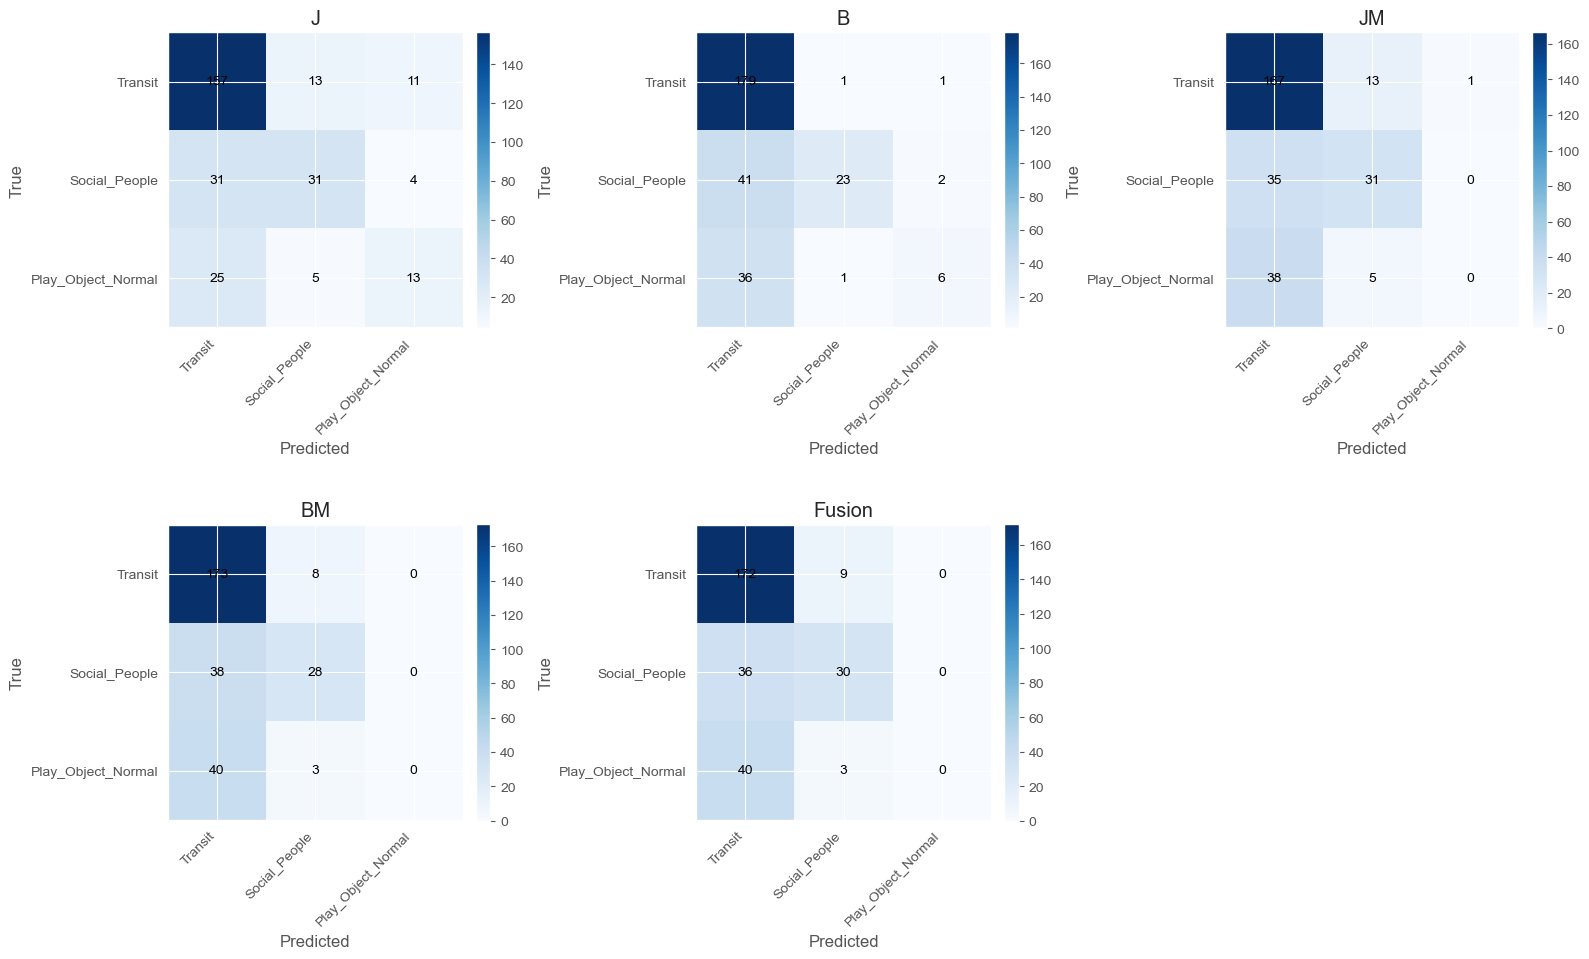

In [5]:
# Confusion matrices for each stream and the fused output
all_results = {**stream_results, 'Fusion': fusion_results}
plot_order = STREAMS + ['Fusion']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes_flat = axes.flatten()
for ax, name in zip(axes_flat, plot_order):
    res = all_results[name]
    plot_confusion(ax, res['cm'], CLASS_NAMES, title=name)
for ax in axes_flat[len(plot_order):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


Per-class metrics (stream x class):


,Stream,Class,Precision,Recall,F1,Support
0,J,Transit,0.737089,0.867403,0.796954,181.0
1,J,Social_People,0.632653,0.469697,0.539130,66.0
2,J,Play_Object_Normal,0.464286,0.302326,0.366197,43.0
3,B,Transit,0.699219,0.988950,0.819222,181.0
4,B,Social_People,0.920000,0.348485,0.505495,66.0
5,B,Play_Object_Normal,0.666667,0.139535,0.230769,43.0
6,JM,Transit,0.695833,0.922652,0.793349,181.0
7,JM,Social_People,0.632653,0.469697,0.539130,66.0
8,JM,Play_Object_Normal,0.000000,0.000000,0.000000,43.0
9,BM,Transit,0.689243,0.955801,0.800926,181.0


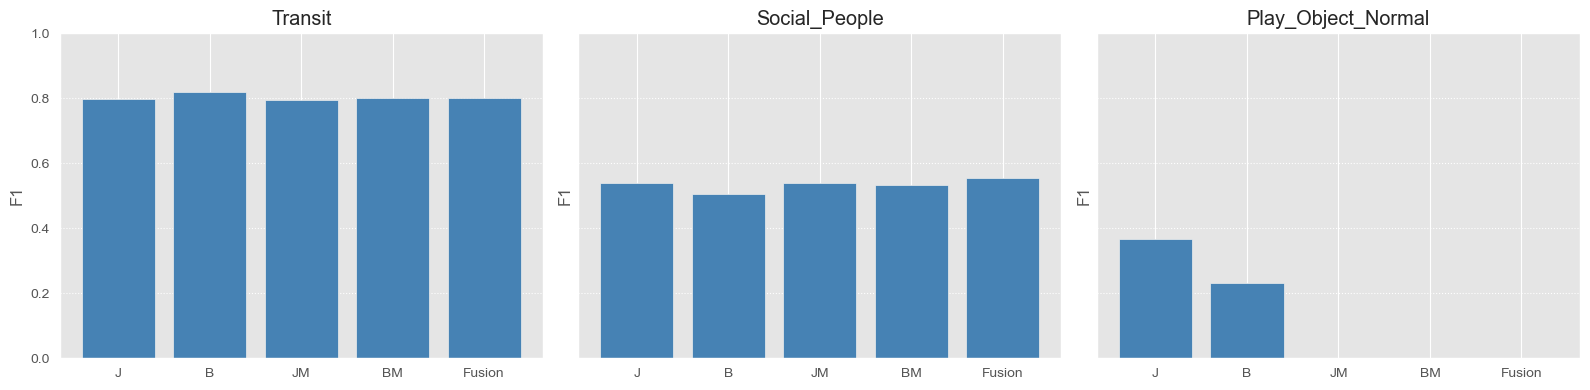

In [6]:
# Per-class metrics across streams (precision/recall/F1)
records = []
all_results = {**stream_results, 'Fusion': fusion_results}
for stream_name, res in all_results.items():
    df = res['report_df'].loc[CLASS_NAMES]
    for cls in CLASS_NAMES:
        row = df.loc[cls]
        records.append({
            'Stream': stream_name,
            'Class': cls,
            'Precision': row['precision'],
            'Recall': row['recall'],
            'F1': row['f1-score'],
            'Support': row['support'],
        })

per_class_df = pd.DataFrame(records)
print('Per-class metrics (stream x class):')
display(per_class_df)

fig, axes = plt.subplots(1, len(CLASS_NAMES), figsize=(16, 4), sharey=True)
for idx, cls in enumerate(CLASS_NAMES):
    ax = axes[idx]
    subset = per_class_df[per_class_df['Class'] == cls]
    ax.bar(subset['Stream'], subset['F1'], color='steelblue')
    ax.set_title(cls)
    ax.set_ylabel('F1')
    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()
